In [1]:
import sys

sys.path.append("..")
from core.DataLoader import (
    DataPreprocessor,
    DataConfig,
    LoadConfig,
    get_load_config_from_yaml,
)
import numpy as np
from importlib import reload
import matplotlib.pyplot as plt
import yaml
import core.assignment_models as Models
from core.reconstruction import MLEvaluator, MLReconstructorBase
import core
import keras


PLOTS_DIR = "plots/plot_histories/"
CONFIG_PATH = "../config/workspace_config_high_level_features.yaml"
CONFIG_PATH_BASELINE = "../config/workspace_config.yaml"
import os

if not os.path.exists(PLOTS_DIR):
    os.makedirs(PLOTS_DIR)


load_config = get_load_config_from_yaml(CONFIG_PATH_BASELINE)
load_config_high_level = get_load_config_from_yaml(
    CONFIG_PATH
)
DataProcessor = DataPreprocessor(load_config)
DataProcessor_high_level = DataPreprocessor(load_config_high_level)

with open(CONFIG_PATH_BASELINE, "r") as file:
    data_configs = yaml.safe_load(file)

data_config = DataProcessor.load_from_npz(
    data_configs["npz_datapath"]["nominal"], max_events=400000
)
X_train, y_train, X_val, y_val = DataProcessor.split_data(test_size=0.1)
data_config_high_level = DataProcessor_high_level.load_from_npz(
    data_configs["npz_datapath"]["nominal"], max_events=400000
)
X_train_high_level, y_train_high_level, X_val_high_level, y_val_high_level = DataProcessor_high_level.split_data(
    test_size=0.1
)
MODEL_DIRS = ["models/assignment_rnn/", "models/assignment_transformer/", "models/assignment_transformer_high_level_features/"]
MODEL_CONFIGS = [data_config, data_config, data_config_high_level]
MODEL_NAMES = ["RNN", "Transformer", "Transformer High Level"]
MODEL_X_TEST = [X_val, X_val, X_val_high_level]
MODEL_Y_TEST = [y_val, y_val, y_val_high_level]

ml_reconstructors = []
ml_evaluators = []
for i in range(len(MODEL_DIRS)):
    reconstructor = MLReconstructorBase(MODEL_CONFIGS[i], name=MODEL_NAMES[i], perform_regression=False)
    reconstructor.load_model(MODEL_DIRS[i] + "model.keras")
    ml_reconstructors.append(reconstructor)

evaluator = MLEvaluator(
    reconstructor=ml_reconstructors,
    X_test=MODEL_X_TEST,
    y_test=MODEL_Y_TEST,
)



2025-11-20 18:18:49.453558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763659129.476631 3461962 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763659129.484387 3461962 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763659129.502460 3461962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763659129.502479 3461962 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1763659129.502482 3461962 computation_placer.cc:177] computation placer alr

Model loaded from models/assignment_rnn/model.keras
Training history loaded from models/assignment_rnn/model_history.npz
Model loaded from models/assignment_transformer/model.keras
Training history loaded from models/assignment_transformer/model_history.npz
Model loaded from models/assignment_transformer_high_level_features/model.keras
Training history loaded from models/assignment_transformer_high_level_features/model_history.npz


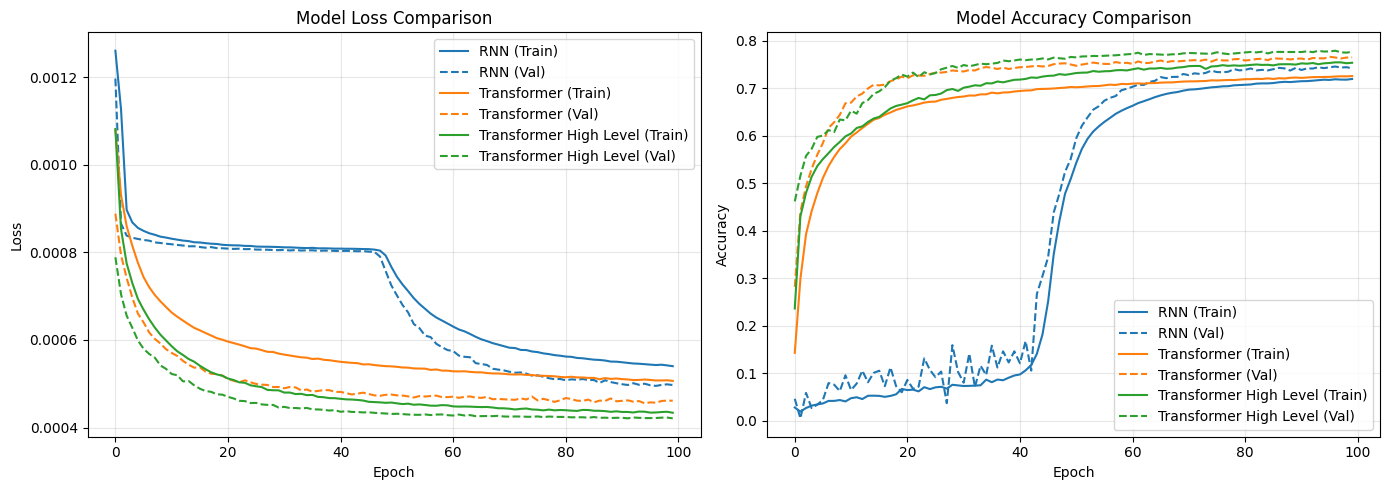

In [2]:
fig, ax = evaluator.plot_training_history()
fig.savefig(PLOTS_DIR + "training_histories_comparison.png")

Computing feature importance for RNN (features: jet, lepton, met)...


I0000 00:00:1763659265.981366 3465151 service.cc:152] XLA service 0x7f2a94005f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763659265.981396 3465151 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
2025-11-20 18:21:06.172038: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatRNN_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 18:21:06.182818: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1763659267.153926 3465151 cuda_dnn.cc:529] Loaded cuDNN version 91500
I0000 00:00:1763659268.235478 3465151 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-20 18:21:11.346312: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert opera

Baseline Assignment Performance: 0.7592
Saved feature importance plot to plots/plot_histories//RNN_feature_importance.png
Computing feature importance for Transformer (features: jet, lepton, met)...


2025-11-20 18:24:19.104327: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 18:24:22.014993: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


Baseline Assignment Performance: 0.7828
Saved feature importance plot to plots/plot_histories//Transformer_feature_importance.png
Computing feature importance for Transformer High Level (features: jet, lepton, met)...


2025-11-20 18:27:04.411407: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert
2025-11-20 18:27:07.511647: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator FeatureConcatTransformerModel_1/met_input_transform_1/assert_equal_1/Assert/Assert


Baseline Assignment Performance: 0.7936
Saved feature importance plot to plots/plot_histories//Transformer High Level_feature_importance.png


[(<Figure size 1000x600 with 1 Axes>,
  <Axes: title={'center': 'Feature Importance - RNN'}, xlabel='Importance Score'>),
 (<Figure size 1000x600 with 1 Axes>,
  <Axes: title={'center': 'Feature Importance - Transformer'}, xlabel='Importance Score'>),
 (<Figure size 1000x600 with 1 Axes>,
  <Axes: title={'center': 'Feature Importance - Transformer High Level'}, xlabel='Importance Score'>)]

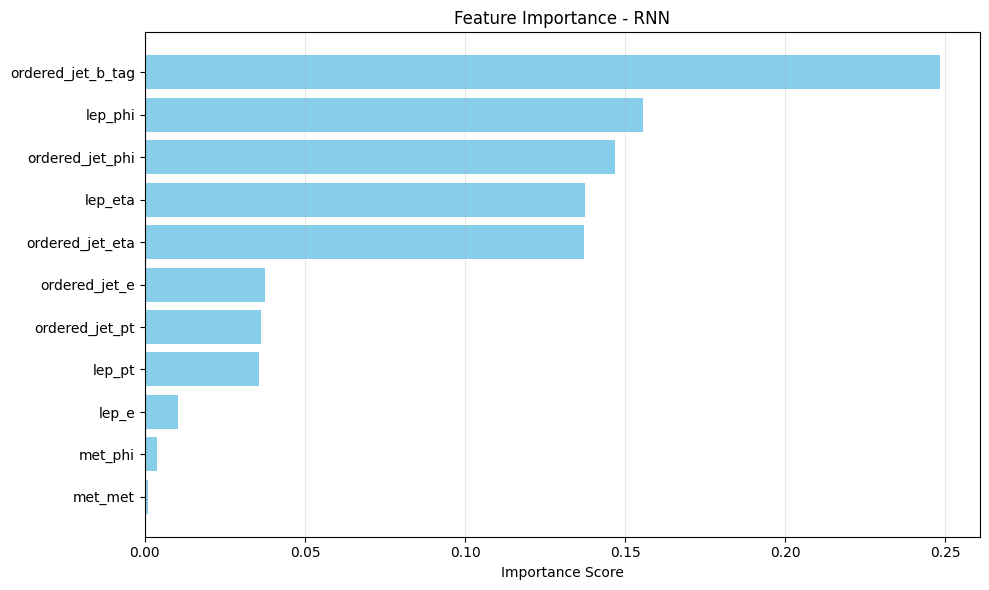

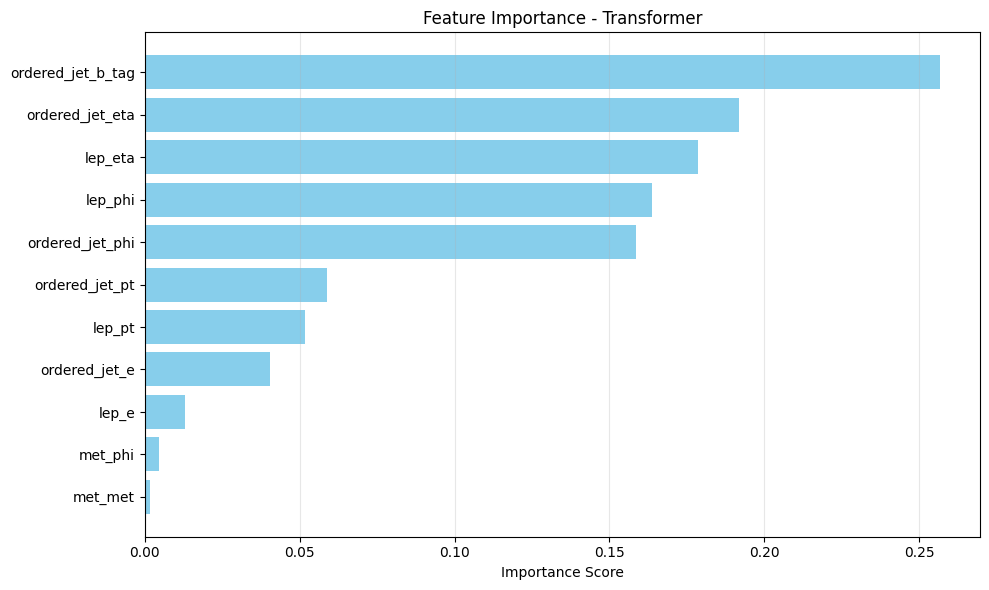

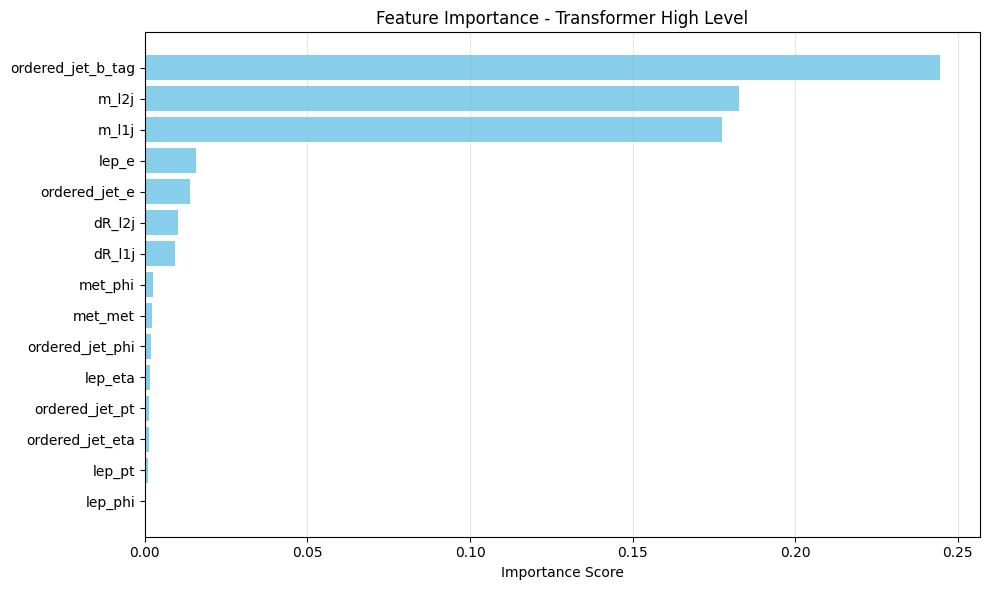

In [3]:
evaluator.plot_feature_importance(save_dir=PLOTS_DIR)